# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
print(tf.__version__)
# if tf.__version__ < '1.14.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.12.0


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# # What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# NUM_CLASSES = 90

In [5]:
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'oid_v4_label_map.pbtxt')

NUM_CLASSES = 601


In [6]:
# # facessd_mobilenet_v2_quantized_320x320_open_image_v4.tar.gz
# # What model to download.
# MODEL_NAME = 'facessd_mobilenet_v2_quantized_320x320_open_image_v4'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/tflite_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join(MODEL_NAME, 'face_label_map.pbtxt')

# NUM_CLASSES = 600  

In [7]:
# # oid_bbox_trainable_label_map is wrong /faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12.tar.gz    
#     # What model to download.
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'oid_bbox_trainable_label_map.pbtxt')

# NUM_CLASSES = 545

In [8]:
# #ok:correct!oid_v4_label_map /ssd_resnet101_v1_fpn_shared_box_predictor_oid_512x512_sync_2019_01_20.tar.gz
    
#     # What model to download.
# MODEL_NAME = 'ssd_resnet101_v1_fpn_shared_box_predictor_oid_512x512_sync_2019_01_20'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'oid_v4_label_map.pbtxt')

# NUM_CLASSES = 601

In [9]:
print(MODEL_NAME)
print(PATH_TO_LABELS)

faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12
data/oid_v4_label_map.pbtxt


## Download Model

In [46]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [10]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [11]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [12]:
print((label_map))


item {
  name: "/m/011k07"
  id: 1
  display_name: "Tortoise"
}
item {
  name: "/m/011q46kg"
  id: 2
  display_name: "Container"
}
item {
  name: "/m/012074"
  id: 3
  display_name: "Magpie"
}
item {
  name: "/m/0120dh"
  id: 4
  display_name: "Sea turtle"
}
item {
  name: "/m/01226z"
  id: 5
  display_name: "Football"
}
item {
  name: "/m/012n7d"
  id: 6
  display_name: "Ambulance"
}
item {
  name: "/m/012w5l"
  id: 7
  display_name: "Ladder"
}
item {
  name: "/m/012xff"
  id: 8
  display_name: "Toothbrush"
}
item {
  name: "/m/012ysf"
  id: 9
  display_name: "Syringe"
}
item {
  name: "/m/0130jx"
  id: 10
  display_name: "Sink"
}
item {
  name: "/m/0138tl"
  id: 11
  display_name: "Toy"
}
item {
  name: "/m/013y1f"
  id: 12
  display_name: "Organ"
}
item {
  name: "/m/01432t"
  id: 13
  display_name: "Cassette deck"
}
item {
  name: "/m/014j1m"
  id: 14
  display_name: "Apple"
}
item {
  name: "/m/014sv8"
  id: 15
  display_name: "Human eye"
}
item {
  name: "/m/014trl"
  id: 16
  di

## Helper code

In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [14]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [15]:
# def run_inference_for_single_image(image, graph):
#   with graph.as_default():
#     with tf.Session() as sess:
#       # Get handles to input and output tensors
#       ops = tf.get_default_graph().get_operations()
#       all_tensor_names = {output.name for op in ops for output in op.outputs}
#       tensor_dict = {}
#       for key in [
#           'num_detections', 'detection_boxes', 'detection_scores',
#           'detection_classes', 'detection_masks'
#       ]:
#         tensor_name = key + ':0'
#         if tensor_name in all_tensor_names:
#           tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
#               tensor_name)
#       if 'detection_masks' in tensor_dict:
#         # The following processing is only for single image
#         detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
#         detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
#         # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
#         real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
#         detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
#         detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
#         detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
#             detection_masks, detection_boxes, image.shape[0], image.shape[1])
#         detection_masks_reframed = tf.cast(
#             tf.greater(detection_masks_reframed, 0.5), tf.uint8)
#         # Follow the convention by adding back the batch dimension
#         tensor_dict['detection_masks'] = tf.expand_dims(
#             detection_masks_reframed, 0)
#       image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

#       # Run inference
#       output_dict = sess.run(tensor_dict,
#                              feed_dict={image_tensor: np.expand_dims(image, 0)})

#       # all outputs are float32 numpy arrays, so convert types as appropriate
#       output_dict['num_detections'] = int(output_dict['num_detections'][0])
#       output_dict['detection_classes'] = output_dict[
#           'detection_classes'][0].astype(np.uint8)
#       output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
#       output_dict['detection_scores'] = output_dict['detection_scores'][0]
#       if 'detection_masks' in output_dict:
#         output_dict['detection_masks'] = output_dict['detection_masks'][0]
#   return output_dict

In [16]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

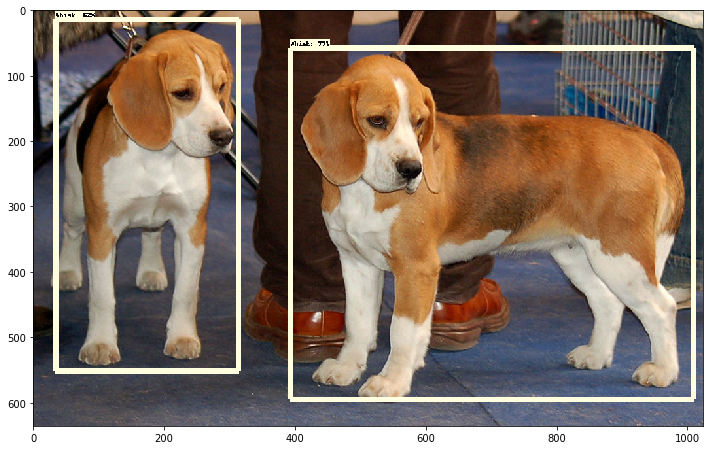

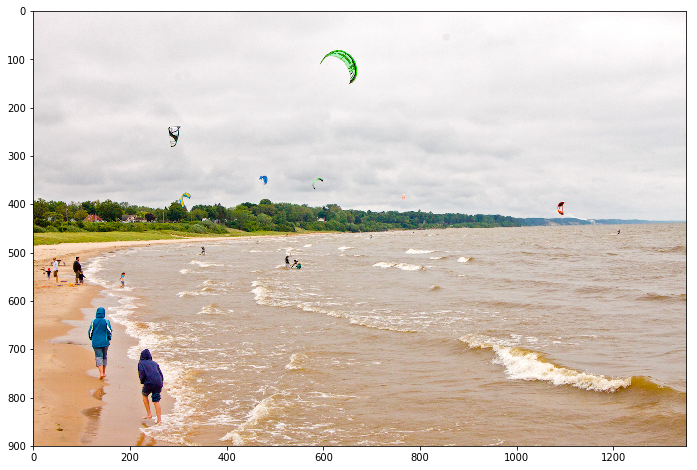

In [23]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [22]:
def run_inference_for_single_image_10times(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            import time
            start_time = time.time()
            numofImages = 10
            
            for ii in range(numofImages+1):
                # Run detection
                loop_start = time.time()
                output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
                loop_end = time.time() - loop_start
                print('Inference time: {} sec @ loop {}.'.format(loop_end,ii))
                if ii == 0:
                    first_time = loop_end

            lfw_time = time.time() - start_time - first_time
            print('Total Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))
    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
      'detection_classes'][0].astype(np.int64)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict





In [20]:
image_path='/root/Mask_RCNN/images/sea_people.jpg'
# image_path='/root/Mask_RCNN/images/seahorse.jpg'
image = Image.open(image_path)
image = image.resize((600,600))
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
image_np_list = image_np.tolist()
image_np.shape

(600, 600, 3)

In [31]:
run_inference_for_single_image_10times(image_np, detection_graph)#gpu

Inference time: 33.51819705963135 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [19]:
run_inference_for_single_image_10times(image_np, detection_graph)#cpu

Inference time: 65.7112946510315 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [36]:
out2 = run_inference_for_single_image_10times(image_np, detection_graph)#gpu

Inference time: 35.377687215805054 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [50]:
out2 = run_inference_for_single_image_10times(image_np, detection_graph)#gpu

Inference time: 0 sec @ loop 28.139413833618164.
Inference time: 1 sec @ loop 0.45125246047973633.
Inference time: 2 sec @ loop 0.4427633285522461.
Inference time: 3 sec @ loop 0.436007022857666.
Inference time: 4 sec @ loop 0.413358211517334.
Inference time: 5 sec @ loop 0.41444969177246094.
Inference time: 6 sec @ loop 0.40434837341308594.
Inference time: 7 sec @ loop 0.4182426929473877.
Inference time: 8 sec @ loop 0.42828917503356934.
Inference time: 9 sec @ loop 0.4369192123413086.
Inference time: 31.987273454666138 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [21]:
out2 = run_inference_for_single_image_10times(image_np, detection_graph)#cpu

Inference time: 0 sec @ loop 31.243155479431152.
Inference time: 1 sec @ loop 2.928840160369873.
Inference time: 2 sec @ loop 2.5605247020721436.
Inference time: 3 sec @ loop 2.7646570205688477.
Inference time: 4 sec @ loop 2.757708787918091.
Inference time: 5 sec @ loop 2.6458113193511963.
Inference time: 6 sec @ loop 2.5626718997955322.
Inference time: 7 sec @ loop 2.6506407260894775.
Inference time: 8 sec @ loop 2.6903305053710938.
Inference time: 9 sec @ loop 2.624969720840454.
Inference time: 10 sec @ loop 2.554682731628418.
Total Inference time: 26.74362325668335 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


{'detection_boxes': array([[0.607871  , 0.581062  , 0.6950947 , 0.6243616 ],
        [0.49428234, 0.6679256 , 0.5511001 , 0.7053484 ],
        [0.6626122 , 0.54388416, 0.7966205 , 0.5815812 ],
        [0.42918602, 0.36303586, 0.5116318 , 0.39055136],
        [0.43626624, 0.6447353 , 0.47210953, 0.6668941 ],
        [0.5474901 , 0.50443697, 0.6247286 , 0.53660625],
        [0.66102827, 0.54912287, 0.79367465, 0.5974335 ],
        [0.6155085 , 0.9389076 , 0.6599011 , 0.98855174],
        [0.66369843, 0.56313455, 0.7753225 , 0.6101411 ],
        [0.59522265, 0.831247  , 0.6383735 , 0.8672153 ],
        [0.38957754, 0.2403834 , 0.42740384, 0.25576797],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.      

In [37]:
out2

{'detection_boxes': array([[0.6589787 , 0.54561204, 0.8009852 , 0.5839165 ],
        [0.60394573, 0.5825082 , 0.69899744, 0.62256676],
        [0.55408263, 0.3064341 , 0.65686333, 0.33018467],
        [0.65195   , 0.56948954, 0.7704125 , 0.6066177 ],
        [0.557035  , 0.6051709 , 0.6340162 , 0.6360176 ],
        [0.49932364, 0.6721295 , 0.55204904, 0.70425034],
        [0.68873763, 0.951488  , 0.724765  , 0.9908426 ],
        [0.6595547 , 0.44830105, 0.7984221 , 0.48279956],
        [0.43059123, 0.36272785, 0.5132959 , 0.38879085],
        [0.61407524, 0.93729734, 0.65812624, 0.9853778 ],
        [0.5224062 , 0.03073485, 0.6406539 , 0.0754189 ],
        [0.43641612, 0.64729595, 0.47137067, 0.66351455],
        [0.41339856, 0.07015598, 0.47772208, 0.09047842],
        [0.52754444, 0.75804806, 0.56139624, 0.7769905 ],
        [0.5023542 , 0.66356176, 0.55236936, 0.6932769 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.      

In [46]:
out2 = run_inference_for_single_image_10times(image_np, detection_graph)#gpu,600*600

Inference time: 34.737098932266235 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [ ]:
def run_inference_for_10_image_10times(images, graph):
    outputs = []
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            import time
            start_time = time.time()
            numofImages = 10
            
            for ii in range(numofImages):
                # Run detection
                loop_a = time.time()
                output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
                outputs.append(output)
                
            lfw_time = time.time() - start_time
            print('Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))
    return outputs








In [21]:
image_np

array([[[  2,  15,   8],
        [  1,  16,   9],
        [  2,  18,   8],
        ...,
        [  0,   1,   5],
        [  0,   1,   5],
        [  0,   1,   5]],

       [[  0,  14,   7],
        [  0,  15,   8],
        [  1,  17,   7],
        ...,
        [  0,   1,   5],
        [  0,   1,   5],
        [  0,   1,   5]],

       [[  0,  14,   7],
        [  0,  16,   6],
        [  2,  18,   8],
        ...,
        [  0,   1,   5],
        [  0,   1,   5],
        [  0,   1,   5]],

       ...,

       [[177, 196, 174],
        [178, 197, 175],
        [179, 197, 175],
        ...,
        [190, 207, 155],
        [192, 206, 157],
        [193, 207, 158]],

       [[177, 197, 170],
        [177, 197, 170],
        [178, 198, 171],
        ...,
        [203, 217, 166],
        [205, 217, 167],
        [206, 218, 168]],

       [[176, 196, 168],
        [177, 197, 169],
        [178, 198, 170],
        ...,
        [211, 224, 171],
        [214, 227, 174],
        [218, 228, 176]]

In [26]:
image_np_list = image_np.tolist()

In [50]:
def run_inference_for_array_10_image_10times_debug(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            import time
            start_time = time.time()
            numofImages = 10
            images = []
            print(image.shape)
            print(np.expand_dims(np.array(image), 0).shape)
            return np.expand_dims(np.array(image), 0)
#             for ii in range(numofImages):
#                 # Run detection
#                 images.append(image.copy())
                
#             output_dict = sess.run(tensor_dict,
#                                  feed_dict={image_tensor: np.expand_dims(np.array(images), 0)})
            lfw_time = time.time() - start_time
            print('Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))
#     return output_dict




In [39]:
run_inference_for_array_10_image_10times(image_np, detection_graph)

ValueError: Cannot feed value of shape (1, 10, 460, 860, 3) for Tensor 'image_tensor:0', which has shape '(?, ?, ?, 3)'

In [51]:
input_data = run_inference_for_array_10_image_10times_debug(image_np, detection_graph)

(460, 860, 3)
(1, 460, 860, 3)


In [47]:
input_data.shape

(1, 460, 860, 3)

In [53]:
def run_inference_for_array_10_image_10times(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            import time
            
            numofImages = 10
            images = []
            for ii in range(numofImages):
                # Run detection
                images.append(image.copy())
            start_time = time.time()
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(np.array(image), 0)})
            lfw_time = time.time() - start_time
            print('1st Inference time: {} sec @ {} images. {}'.format(lfw_time, 1,MODEL_NAME))

            start_time = time.time()
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.array(images)})
            lfw_time = time.time() - start_time
            print('Total Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))
    return output_dict





In [53]:
out_dict = run_inference_for_array_10_image_10times(image_np_list, detection_graph)#cpu32

Inference time: 87.21128916740417 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [21]:
out_dict = run_inference_for_array_10_image_10times(image_np_list, detection_graph)#gpu

Inference time: 72.4646897315979 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [54]:
out_dict = run_inference_for_array_10_image_10times(image_np_list, detection_graph)#gpu

1st Inference time: 30.587434768676758 sec @ 1 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12
Total Inference time: 6.2550132274627686 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [26]:
# images = []
# for ii in range(10):
#     # Run detection
#     images.append(image_np_list.copy())
np.array(images).shape

(10, 1800, 2400, 3)

In [27]:
image_np.shape

(1800, 2400, 3)

In [30]:
out_dict

{'detection_boxes': array([[[0.65897876, 0.54561204, 0.80098516, 0.5839165 ],
         [0.60394573, 0.5825082 , 0.69899744, 0.62256676],
         [0.55408263, 0.30643412, 0.6568634 , 0.3301847 ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.65897876, 0.54561204, 0.80098516, 0.5839165 ],
         [0.60394573, 0.5825082 , 0.69899744, 0.62256676],
         [0.55408263, 0.30643412, 0.6568634 , 0.3301847 ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.65897876, 0.54561204, 0.80098516, 0.5839165 ],
         [0.60394573, 0.5825082 , 0.69899744, 0.62256676],
         [0.55408263, 0.30643412, 0.6568634 , 0.3301847 ],
         ...,
         [0.        , 0.        , 0.        , 0.

In [44]:
out_dict = run_inference_for_array_10_image_10times(image_np_list, detection_graph)#gpu#600*600

Inference time: 37.55296969413757 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [45]:
out_dict

{'detection_boxes': array([[[0.60787106, 0.581062  , 0.69509465, 0.6243616 ],
         [0.49428234, 0.6679256 , 0.5511001 , 0.7053484 ],
         [0.66261214, 0.54388416, 0.79662055, 0.5815812 ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.60787106, 0.581062  , 0.69509465, 0.6243616 ],
         [0.49428234, 0.6679256 , 0.5511001 , 0.7053484 ],
         [0.66261214, 0.54388416, 0.79662055, 0.5815812 ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.60787106, 0.581062  , 0.69509465, 0.6243616 ],
         [0.49428234, 0.6679256 , 0.5511001 , 0.7053484 ],
         [0.66261214, 0.54388416, 0.79662055, 0.5815812 ],
         ...,
         [0.        , 0.        , 0.        , 0.